In [1]:
import math
import pickle
import random
from typing import List, Tuple

import pandas as pd
import numpy as np
import torch
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm

from utils import compute_ideal_dcg, ndcg


class Solution:
    def __init__(self, n_estimators: int = 100, lr: float = 0.5, ndcg_top_k: int = 10,
                 subsample: float = 0.6, colsample_bytree: float = 0.9,
                 max_depth: int = 5, min_samples_leaf: int = 8):
        self._prepare_data()

        self.ndcg_top_k = ndcg_top_k
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

        self.subsample = subsample
        self.colsample_bytree = colsample_bytree

        self._estimators = []
        self._col_indexes = []

    def _get_data(self) -> List[np.ndarray]:
        """
        Загрузка данных MSRANK
        """
        train_df, test_df = msrank_10k()

        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[0].values
        query_ids_train = train_df[1].values.astype(int)

        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[0].values
        query_ids_test = test_df[1].values.astype(int)

        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        """
        Подготовка данных, сохранение в качестве тензоров
        """
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()
        
        self.X_train = self._scale_features_in_query_groups(X_train, self.query_ids_train)
        self.X_test = self._scale_features_in_query_groups(X_test, self.query_ids_test)

        self.ys_train = torch.as_tensor(y_train, dtype=torch.float32).view(-1, 1)
        self.ys_test = torch.as_tensor(y_test, dtype=torch.float32).view(-1, 1)

    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray,
                                        inp_query_ids: np.ndarray) -> np.ndarray:
        """
        Масштабирование признаков, происходит в каждом запросе независимо
        """
        scaled_features = np.zeros_like(inp_feat_array)
        
        for query in np.unique(inp_query_ids):
            idxs = np.where(inp_query_ids == query)[0]
            scaled_features[idxs] = StandardScaler().fit_transform(inp_feat_array[idxs])
        return torch.as_tensor(scaled_features, dtype=torch.float32)

    def _train_one_tree(self, cur_tree_idx: int,
                        train_preds: torch.FloatTensor
                        ) -> Tuple[DecisionTreeRegressor, np.ndarray]:
        """
        Обучить одно дерево: считаем lambda, обучаем дерево их предсказывать
        """
        np.random.seed(cur_tree_idx)
        
        tree_ = DecisionTreeRegressor(
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            random_state=cur_tree_idx
        )

        lambdas = self._compute_lambdas(self.ys_train, train_preds)

        n_rows, n_cols = self.X_train.shape
        cols_to_train = np.random.choice(np.arange(n_cols), size=np.ceil(n_cols*self.colsample_bytree).astype(int), replace=False)
        rows_to_train = np.random.choice(np.arange(n_rows), size=np.ceil(n_rows*self.subsample).astype(int))

        x_train = self.X_train[:, cols_to_train]
        x_train = x_train[rows_to_train]
        y_train = lambdas[rows_to_train]
        tree_.fit(x_train, y_train)
        
        return tree_, cols_to_train

    def _calc_data_ndcg(self, queries_list: np.ndarray,
                        true_labels: torch.FloatTensor, preds: torch.FloatTensor) -> float:
        """
        Подсчет NDCG в группах, для каждого запроса с последующим усреднением по всем
        """
        ndcgs = []
        preds = preds.flatten()
        true_labels = true_labels.flatten()
        
        for query in np.unique(queries_list):
            query_idxs = np.where(queries_list == query)[0]
            
            ndcg = self._ndcg_k(true_labels[query_idxs], preds[query_idxs], ndcg_top_k=self.ndcg_top_k)

            ndcgs.append(ndcg)
        return np.mean(ndcgs)

    def fit(self):
        """
        Обучение модели на данных MSRANK
        Также отслеживается метрика NDCG для тренировочных и тестовых данных, с последующим обрезанием итоговой модели
        """
        np.random.seed(0)
        preds = torch.zeros((self.X_train.shape[0], 1), dtype=torch.float32)
        test_preds = torch.zeros((self.X_test.shape[0], 1), dtype=torch.float32)

        train_ndcgs = []
        test_ndcgs = []

        best_i = 0
        best_score = 0

        for cur_tree_idx in tqdm(range(self.n_estimators)):
            tree_, col_idx = self._train_one_tree(
                cur_tree_idx=cur_tree_idx,
                train_preds=preds
            )
            self._estimators.append(tree_)
            self._col_indexes.append(col_idx)

            tree_predict = tree_.predict(self.X_train[:, col_idx])
            tree_predict = torch.as_tensor(tree_predict, dtype=torch.float32).view(-1, 1)

            preds -= self.lr * tree_predict

            train_ndcg = self._calc_data_ndcg(self.query_ids_train, self.ys_train, preds)
            train_ndcgs.append(train_ndcg)

            test_tree_predict = tree_.predict(self.X_test[:, col_idx])
            test_tree_predict = torch.as_tensor(test_tree_predict, dtype=torch.float32).view(-1, 1)
            test_preds -= self.lr * test_tree_predict
            
            test_ndcg = self._calc_data_ndcg(self.query_ids_test, self.ys_test, test_preds)
            test_ndcgs.append(test_ndcg)

            if test_ndcg > best_score:
                best_score = test_ndcg
                best_i = cur_tree_idx

        print(f'Best iteration: {best_i}, shrink model to the first {best_i} iterations')
        self._estimators = self._estimators[:best_i+1]

        return train_ndcgs, test_ndcgs, best_i

    def predict(self, data: torch.FloatTensor) -> torch.FloatTensor:
        """
        Предсказание модели
        """
        preds = torch.zeros((data.shape[0], 1), dtype=torch.float32)
        
        for i, tree_ in enumerate(self._estimators):
            data_to_predict = data[:, self._col_indexes[i]]

            tree_pred = tree_.predict(data_to_predict)
            tree_pred = torch.as_tensor(tree_pred, dtype=torch.float32).view(-1, 1)

            preds -= self.lr * tree_pred

        return preds
            

    def _compute_lambdas(self, y_true: torch.FloatTensor, y_pred: torch.FloatTensor) -> torch.FloatTensor:
        """
        Код для подсчета lambda значений, подробнее: https://www.microsoft.com/en-us/research/uploads/prod/2016/02/MSR-TR-2010-82.pdf
        """
        
        def compute_lambdas(y_true, y_pred, ndcg_scheme='exp2'):
            # рассчитаем нормировку, IdealDCG
            ideal_dcg = compute_ideal_dcg(y_true, gain_scheme=ndcg_scheme)
            N = 1 / ideal_dcg
            
            # рассчитаем порядок документов согласно оценкам релевантности
            _, rank_order = torch.sort(y_true, descending=True, axis=0)
            rank_order += 1
            
            with torch.no_grad():
                # получаем все попарные разницы скоров в батче
                pos_pairs_score_diff = 1.0 + torch.exp((y_pred - y_pred.t()))
                
                # поставим разметку для пар, 1 если первый документ релевантнее
                # -1 если второй документ релевантнее
                Sij = compute_labels_in_batch(y_true)
                # посчитаем изменение gain из-за перестановок
                gain_diff = compute_gain_diff(y_true, ndcg_scheme)
                
                # посчитаем изменение знаменателей-дискаунтеров
                decay_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
                # посчитаем непосредственное изменение nDCG
                delta_ndcg = torch.abs(N * gain_diff * decay_diff)
                # посчитаем лямбды
                lambda_update =  (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff) * delta_ndcg
                lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)
                
                return lambda_update
    
    
        def compute_labels_in_batch(y_true):
            
            # разница релевантностей каждого с каждым объектом
            rel_diff = y_true - y_true.t()
            
            # 1 в этой матрице - объект более релевантен
            pos_pairs = (rel_diff > 0).type(torch.float32)
            
            # 1 тут - объект менее релевантен
            neg_pairs = (rel_diff < 0).type(torch.float32)
            Sij = pos_pairs - neg_pairs
            return Sij
        
        def compute_gain_diff(y_true, gain_scheme):
            if gain_scheme == "exp2":
                gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.t())
            elif gain_scheme == "diff":
                gain_diff = y_true - y_true.t()
            else:
                raise ValueError(f"{gain_scheme} method not supported")
            return gain_diff

        lambdas = compute_lambdas(y_true, y_pred)
        return lambdas

    def _ndcg_k(self, ys_true, ys_pred, ndcg_top_k) -> float:
        """
        Подсчет метрики NDCG в топ k значениях
        """
        
        def compute_gain(y_value: float, gain_scheme: str) -> float:
            assert gain_scheme in ['const', 'exp2']
            if gain_scheme == 'const':
                return y_value
            elif gain_scheme == 'exp2':
                return 2 ** y_value - 1
        
        
        def dcg_k(ys_true: torch.Tensor, ys_pred: torch.Tensor, gain_scheme: str, k: int) -> float:
            ys_true, ys_pred = ys_true.flatten(), ys_pred.flatten()
            
            dcg_value = 0
            _, sorted_ys_pred_idx = torch.sort(ys_pred, descending=True)
            for i, rel in enumerate(ys_true[sorted_ys_pred_idx][:k]):
                dcg_value += compute_gain(rel, gain_scheme=gain_scheme) / math.log2(i+2)
            return dcg_value.item()

        # расчет по экспоненциальной формуле
        try:
            dcg_value = dcg_k(ys_true, ys_pred, gain_scheme='exp2', k=ndcg_top_k)
            perfect_dcg = dcg_k(ys_true, ys_true, gain_scheme='exp2', k=ndcg_top_k)

            ndcg_value = dcg_value / perfect_dcg
        except ZeroDivisionError:
            ndcg_value = 0
        
        return ndcg_value

    def save_model(self, path: str):
        """
        Сохранение модели
        """
        params_to_save = {
            '_estimators': self._estimators,
            '_col_indexes': self._col_indexes,
            'lr': self.lr
        }

        with open(path, 'wb') as f:
            pickle.dump(params_to_save, f)

    def load_model(self, path: str):
        """
        Загрузка модели inplace
        """
        with open(path, 'rb') as f:
            params = pickle.load(f)

        self._estimators = params['_estimators']
        self._col_indexes = params['_col_indexes']
        self.lr = params['lr']

E:\MyProjects\venvs\uplift\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
solution = Solution()

In [3]:
train_ndcgs, test_ndcgs, best_i = solution.fit()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]

Best iteration: 94, shrink model to the first 94 iterations


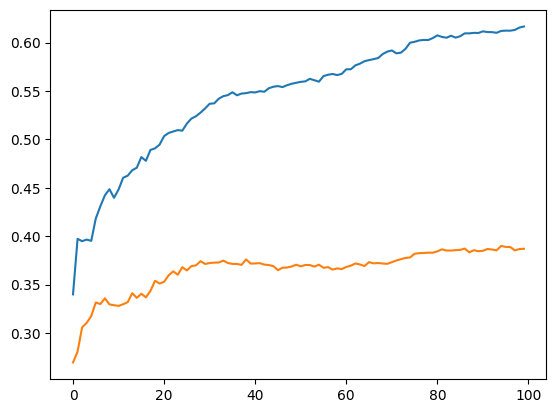

In [4]:
import matplotlib.pyplot as plt

plt.plot(train_ndcgs)
plt.plot(test_ndcgs);

In [5]:
solution.save_model('./lambdamart.pkl')

In [6]:
solution = Solution()
solution.load_model('./lambdamart.pkl')

In [7]:
test_preds = solution.predict(solution.X_test)

In [8]:
solution._calc_data_ndcg(solution.query_ids_test, solution.ys_test, test_preds), test_ndcgs[best_i]

(0.3898748383608827, 0.3898748383608827)

In [9]:
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'lr': trial.suggest_float('lr', 0.01, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'ndcg_top_k': 10
    }
    
    model = Solution(**params)
    train_ndcgs, test_ndcgs, best_i = model.fit()
    
    return test_ndcgs[best_i]

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-02-03 20:34:20,881] A new study created in memory with name: no-name-8181d28a-0d2d-434e-b8af-ea48a5b510e8
100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [02:50<00:00,  1.66s/it]
[I 2025-02-03 20:37:12,097] Trial 0 finished with value: 0.42122678958899334 and parameters: {'max_depth': 11, 'n_estimators': 103, 'lr': 0.3580436334128195, 'min_samples_leaf': 58, 'subsample': 0.8286663974408439, 'colsample_bytree': 0.7235410203054733}. Best is trial 0 with value: 0.42122678958899334.


Best iteration: 98, shrink model to the first 98 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [05:58<00:00,  1.37s/it]
[I 2025-02-03 20:43:11,619] Trial 1 finished with value: 0.4226809547624109 and parameters: {'max_depth': 14, 'n_estimators': 263, 'lr': 0.5042636024691471, 'min_samples_leaf': 79, 'subsample': 0.7839947309968889, 'colsample_bytree': 0.22700735628976806}. Best is trial 1 with value: 0.4226809547624109.


Best iteration: 255, shrink model to the first 255 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [06:58<00:00,  1.57s/it]
[I 2025-02-03 20:50:10,335] Trial 2 finished with value: 0.4433211372526488 and parameters: {'max_depth': 13, 'n_estimators': 267, 'lr': 0.4913654636391831, 'min_samples_leaf': 63, 'subsample': 0.8781103393066291, 'colsample_bytree': 0.48727511307559246}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 263, shrink model to the first 263 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [04:12<00:00,  1.43s/it]
[I 2025-02-03 20:54:23,525] Trial 3 finished with value: 0.4045871463301062 and parameters: {'max_depth': 4, 'n_estimators': 177, 'lr': 0.20322525071695244, 'min_samples_leaf': 41, 'subsample': 0.9948744709328557, 'colsample_bytree': 0.6661004159464016}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 171, shrink model to the first 171 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 291/291 [06:15<00:00,  1.29s/it]
[I 2025-02-03 21:00:39,417] Trial 4 finished with value: 0.4072509060898387 and parameters: {'max_depth': 3, 'n_estimators': 291, 'lr': 0.633302553641935, 'min_samples_leaf': 27, 'subsample': 0.7305747083945751, 'colsample_bytree': 0.326568178857373}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 129, shrink model to the first 129 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [02:26<00:00,  1.42s/it]
[I 2025-02-03 21:03:06,087] Trial 5 finished with value: 0.3668116583681518 and parameters: {'max_depth': 3, 'n_estimators': 103, 'lr': 0.03360530190413289, 'min_samples_leaf': 9, 'subsample': 0.844651547876835, 'colsample_bytree': 0.9503536877474335}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 88, shrink model to the first 88 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [05:23<00:00,  1.44s/it]
[I 2025-02-03 21:08:30,060] Trial 6 finished with value: 0.40937331232949015 and parameters: {'max_depth': 5, 'n_estimators': 225, 'lr': 0.9589883020042064, 'min_samples_leaf': 18, 'subsample': 0.6140400146734708, 'colsample_bytree': 0.8090252322796037}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 216, shrink model to the first 216 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [06:07<00:00,  1.45s/it]
[I 2025-02-03 21:14:38,627] Trial 7 finished with value: 0.40714088053364195 and parameters: {'max_depth': 11, 'n_estimators': 254, 'lr': 0.08588775766452696, 'min_samples_leaf': 99, 'subsample': 0.4066582289766284, 'colsample_bytree': 0.8080148834839878}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 207, shrink model to the first 207 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 184/184 [04:19<00:00,  1.41s/it]
[I 2025-02-03 21:18:58,921] Trial 8 finished with value: 0.42391134144415593 and parameters: {'max_depth': 5, 'n_estimators': 184, 'lr': 0.3774373011923074, 'min_samples_leaf': 70, 'subsample': 0.8687401863544195, 'colsample_bytree': 0.560044381481824}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 175, shrink model to the first 175 iterations


100%|████████████████████████████████████████████████████████████████████████████████| 282/282 [08:12<00:00,  1.75s/it]
[I 2025-02-03 21:27:11,895] Trial 9 finished with value: 0.427803385035281 and parameters: {'max_depth': 10, 'n_estimators': 282, 'lr': 0.41353854826275377, 'min_samples_leaf': 64, 'subsample': 0.4960698188507283, 'colsample_bytree': 0.8859482011310462}. Best is trial 2 with value: 0.4433211372526488.


Best iteration: 275, shrink model to the first 275 iterations


 46%|████████████████████████████████████▌                                           | 102/223 [02:51<03:23,  1.68s/it]
[W 2025-02-03 21:30:03,535] Trial 10 failed with parameters: {'max_depth': 16, 'n_estimators': 223, 'lr': 0.7358913440323582, 'min_samples_leaf': 41, 'subsample': 0.9699733338767, 'colsample_bytree': 0.5074941836333766} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "E:\MyProjects\venvs\uplift\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\roynys_pc\AppData\Local\Temp\ipykernel_9540\1899621134.py", line 15, in objective
    train_ndcgs, test_ndcgs, best_i = model.fit()
                                      ^^^^^^^^^^^
  File "C:\Users\roynys_pc\AppData\Local\Temp\ipykernel_9540\1332862113.py", line 136, in fit
    tree_, col_idx = self._train_one_tree(
                     ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\roy

KeyboardInterrupt: 

In [11]:
study.best_params

{'max_depth': 13,
 'n_estimators': 267,
 'lr': 0.4913654636391831,
 'min_samples_leaf': 63,
 'subsample': 0.8781103393066291,
 'colsample_bytree': 0.48727511307559246}

In [12]:
solution = Solution(**study.best_params)
solution.fit()

100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [07:00<00:00,  1.57s/it]

Best iteration: 263, shrink model to the first 263 iterations


([0.41302315221985325,
  0.43826737652223674,
  0.4654168880019816,
  0.49372923043813927,
  0.5115660741823991,
  0.5132232243464975,
  0.5236813918418727,
  0.5291039372221847,
  0.5343118118038889,
  0.5484809938057554,
  0.5549373898634037,
  0.5574305140220993,
  0.5642721822429536,
  0.5678680630112495,
  0.5746093523709634,
  0.5742314433841441,
  0.5764175247730311,
  0.5797449394049087,
  0.5805026322682675,
  0.5866149334821666,
  0.5839480612400046,
  0.5832221876644746,
  0.5879999638958289,
  0.5938864019237323,
  0.6023891809283001,
  0.5988126183653776,
  0.6099782115559642,
  0.6087370254523825,
  0.6083761896591977,
  0.606795512794974,
  0.6112291565303711,
  0.611384579449673,
  0.6125247853181042,
  0.613094174711406,
  0.6173027765445119,
  0.617939211140932,
  0.6206134912937475,
  0.6202896802736969,
  0.6228127404026205,
  0.6211640808901749,
  0.6251408577898202,
  0.6256881643880576,
  0.6296389842435431,
  0.6281472758585976,
  0.6305426019926962,
  0.6345578

In [14]:
test_preds = solution.predict(solution.X_test)
solution._calc_data_ndcg(solution.query_ids_test, solution.ys_test, test_preds)

0.4433211372526488